In [1]:
import numpy as np
import matplotlib.pyplot as plt
from casadi import *
%matplotlib notebook

In [2]:
import os, sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

<IPython.core.display.Javascript object>


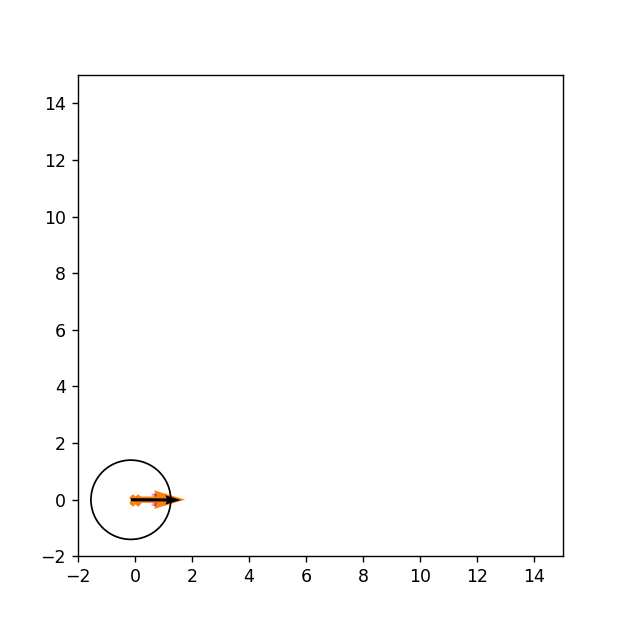

<ipython-input-3-2fc1e4be8c34>:134: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cols = np.interp(cols, (cols.min(), cols.max()), (0, 1)).astype(np.float)


DONE. Max Iterations Exceeded threshold!
DONE. Max Iterations Exceeded threshold!
DONE. Max Iterations Exceeded threshold!
DONE. Running loss less than threshold!


In [3]:
# Time horizon
T = 5
# Resolution
dt = 0.25
# Steps
N = int(T/dt)
# Wheel base
L = 2.7

opti = Opti() # Optimization problem

# ---- decision variables ---------
X = opti.variable(N+1, 4) # state trajectory x, y, theta, v
U = opti.variable(N, 2)   # control trajectory (accleration, steer)

# Motion model
def f(x, u, dt):
    # This function return the change in state wrt time
    # X = [x, y, theta, v, phi]
    # dx/dt = f(x,u) = [dx, dy, d_theta, v]
    return horzcat(
        x[0] + x[3]*np.cos(x[2]) * dt, 
        x[1] + x[3]*np.sin(x[2]) * dt, 
        x[2] + x[3]*np.tan(u[1])/L * dt, 
        x[3] + u[0] * dt)

# Direct Multiple shooting formulation
for k in range(N):
    opti.subject_to(
        X[k+1, :] == f(X[k, :], U[k, :], dt)
    ) # close the gaps

# ---- constraints -----------
opti.subject_to(opti.bounded(-7.75, X[:, 3], 77.75))   # track speed limit
opti.subject_to(opti.bounded(-12.0, U[:, 0], 4.0))   # steering angle limit
opti.subject_to(opti.bounded(-0.575959, U[:, 1], 0.575959))   # steering angle limit

# ---- Params ----
Xi = opti.parameter(1, 4)
Xf = opti.parameter(1, 4)

# ---- Initial conditions --------
opti.subject_to(X[0, :] == Xi)

# Specifying initial and final state param
opti.set_value(Xi, [0.0, 0.0, 0.0, 0.0])
# opti.set_value(Xf, [10.0, 10.0, 0.0, 0.0])

# Running penalty
running_pen = np.eye(4)
running_pen[0, 0] = 1 # x loss penalty
running_pen[1, 1] = 1 # y loss penalty
running_pen[2, 2] = 0  # theta loss penalty
running_pen[3, 3] = 0  # v loss penalty

# Final state penalty
Xf_pen = np.eye(4)
Xf_pen[0, 0] = 1 # x loss penalty
Xf_pen[1, 1] = 1 # y loss penalty
Xf_pen[2, 2] = 100  # theta loss penalty
Xf_pen[3, 3] = 100  # v loss penalty

# Control penalty
cont_pen = np.eye(2)
cont_pen[0, 0] = 2
cont_pen[1, 1] = 2

# Formulating a loss using variables and params
loss = sum([(X[k, :] - Xf)@running_pen@(X[k, :] - Xf).T for k in range(N+1)])
loss += (X[-1, :] - Xf)@Xf_pen@(X[-1, :] - Xf).T
loss += sum([U[k, :]@cont_pen@U[k, :].T for k in range(N)])

# Plotting results
%matplotlib notebook

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.set_title("Trajectory")
plt.ion()

fig.show()
fig.canvas.draw()

# Goal list (waypoints)
goals = [
    [5, 12, 0, 0],
    [10, 10, 0, 0],
    [10, 0, 0, 0],
    [0, 0, 0, 0]
]

# Optimizing for goals in sequence
for goal in goals:
    # Specifying goal
    opti.set_value(Xf, goal)
    
    running_loss = 1000000
    iterc = 0
    # Starting optimization loop
    while True:

        # ---- objective          ---------
        opti.minimize(loss)

        with HiddenPrints():
            # ---- solve NLP              ------
            solver = opti.solver("ipopt") # set numerical backend
            sol = opti.solve()   # actual solve

        # Evaluating solution
        xs = sol.value(X[:, 0])
        ys = sol.value(X[:, 1])
        thetas = sol.value(X[:, 2])
        vs = sol.value(X[:, 3])
        running_loss = sol.value(loss)
        iterc += 1

        # Terminating conditions
        if(running_loss < 0.1):
            print("DONE. Running loss less than threshold!")
            break

        if(iterc > 50):
            print("DONE. Max Iterations Exceeded threshold!")
            break

        # Plotting the solution
        # Direction cosines for quiver
        Us = np.cos(thetas)
        Vs = np.sin(thetas)

        # Creating colors array based on velocity
        cols = np.abs(vs)
        cols = np.interp(cols, (cols.min(), cols.max()), (0, 1)).astype(np.float)
        cols3 = [(cols[x], 0, 1-(cols[x])) for x in range(len(cols))]

        ax.clear()
        
        # Trajectory arrows
        ax.quiver(xs, ys, Us, Vs, color=cols3, units='inches', alpha=0.2, width=0.035, scale=3)
        
        # Goal mark
        plt.scatter(goal[0], goal[1], color="#ff7f0e", marker="X")
        # Goal arrow
        plt.quiver(goal[0], goal[1], np.cos(goal[2]), np.sin(goal[2]),
                   color="#ff7f0e", units='inches', alpha=1, width=0.05, scale=2.5)
        
        # Robot mark
        circle = plt.Circle((xs[0], ys[0]), 1.4, color='k', fill=False)
        plt.gca().add_patch(circle)
        # Robot arrow
        plt.quiver(xs[0], ys[0], Us[0], Vs[0],
                   color="k", units='inches', alpha=1, width=0.025, scale=2.5)
        
        # plt.axis("equal")
        plt.xlim(-2, 15)
        plt.ylim(-2, 15)
        fig.canvas.draw()
        # plt.pause(dt)

        # CRUCIAL
        # Setting intial conditions for the next iteration
        opti.set_value(Xi, f(sol.value(X[0, :]), sol.value(U[0, :]), dt))